In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score
from sklearn.datasets import make_classification
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import r2_score

from arbitragelab.ml_approach.rnn import RecurrentNeuralNetwork

In /home/aaron/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/aaron/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/aaron/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
Using TensorFlow backend.


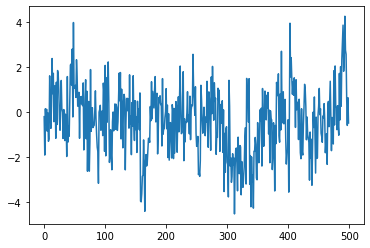

In [3]:
## Generate Synthetic Time Series Data
import random
import math
# https://nbviewer.jupyter.org/github/tirthajyoti/Machine-Learning-with-Python/blob/master/Synthetic_data_generation/Synth_Time_series.ipynb

# cylinder bell funnel based on "Learning comprehensible descriptions of multivariate time series"
def generate_bell(length, amplitude, default_variance):
    bell = np.random.normal(0, default_variance, length) + amplitude * np.arange(length)/length
    return bell

def generate_funnel(length, amplitude, default_variance):
    funnel = np.random.normal(0, default_variance, length) + amplitude * np.arange(length)[::-1]/length
    return funnel

def generate_cylinder(length, amplitude, default_variance):
    cylinder = np.random.normal(0, default_variance, length) + amplitude
    return cylinder

std_generators = [generate_bell, generate_funnel, generate_cylinder]

def generate_pattern_data(length=100, avg_pattern_length=5, avg_amplitude=1, 
                          default_variance = 1, variance_pattern_length = 10, variance_amplitude = 2, 
                          generators = std_generators, include_negatives = True):
    data = np.random.normal(0, default_variance, length)
    current_start = random.randint(0, avg_pattern_length)
    current_length = current_length = max(1, math.ceil(random.gauss(avg_pattern_length, variance_pattern_length)))

    while current_start + current_length < length:
        generator = random.choice(generators)
        current_amplitude = random.gauss(avg_amplitude, variance_amplitude)

        while current_length <= 0:
            current_length = -(current_length-1)
        pattern = generator(current_length, current_amplitude, default_variance)

        if include_negatives and random.random() > 0.5:
            pattern = -1 * pattern

        data[current_start : current_start + current_length] = pattern

        current_start = current_start + current_length + random.randint(0, avg_pattern_length)
        current_length = max(1, math.ceil(random.gauss(avg_pattern_length, variance_pattern_length)))

    return np.array(data)

n_data= [50, 150, 500]
n_pattern_length = [5,10,20]

synth_dataset = generate_pattern_data(length=500, avg_pattern_length=20)

plt.plot( synth_dataset )

In [5]:

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 19
# split into samples
X, y = split_sequence(synth_dataset, n_steps)


# Regression

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [7]:

n_features = 1
# reshape from [samples, timesteps] into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))


regressor = RecurrentNeuralNetwork((n_steps, n_features), num_outputs=1, loss_fn="mean_squared_error", 
                                  optmz="adam", metrics=["accuracy"], hidden_layer_activation_function="relu",
                                  output_layer_act_func="linear")

regressor.build()

regressor.fit(X_train, y_train, epochs=30)

Epoch 1/30
336/336 [==============================] - 1s 2ms/step - loss: 2.2274 - accuracy: 0.0000e+00
Epoch 2/30
336/336 [==============================] - 0s 502us/step - loss: 1.8688 - accuracy: 0.0000e+00
Epoch 3/30
336/336 [==============================] - 0s 734us/step - loss: 1.7430 - accuracy: 0.0000e+00
Epoch 4/30
336/336 [==============================] - 0s 492us/step - loss: 1.6754 - accuracy: 0.0000e+00
Epoch 5/30
336/336 [==============================] - 0s 551us/step - loss: 1.5858 - accuracy: 0.0000e+00
Epoch 6/30
336/336 [==============================] - 0s 465us/step - loss: 1.5376 - accuracy: 0.0000e+00
Epoch 7/30
336/336 [==============================] - 0s 412us/step - loss: 1.5202 - accuracy: 0.0000e+00
Epoch 8/30
336/336 [==============================] - 0s 428us/step - loss: 1.5246 - accuracy: 0.0000e+00
Epoch 9/30
336/336 [==============================] - 0s 458us/step - loss: 1.5254 - accuracy: 0.0000e+00
Epoch 10/30
336/336 [===========================

0.05105834331937298


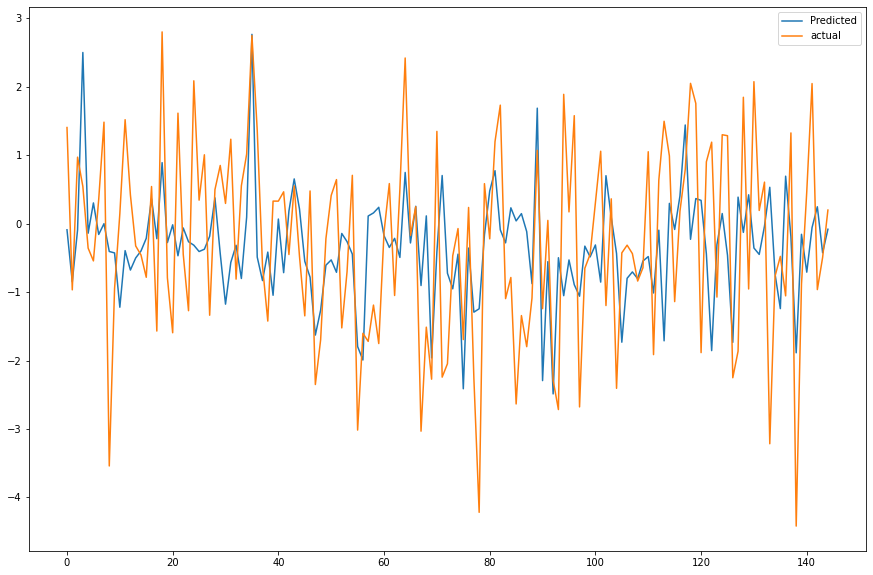

In [8]:
# demonstrate prediction
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
print(r2_score(y_test, regressor.predict(X_test, verbose=0)))

plt.figure(figsize=(15, 10))
plt.plot(regressor.predict(X_test))
plt.plot(y_test)

plt.legend(["Predicted", "actual"])

# Classification

In [9]:
y = np.sign(y)
y[y==-1] = 0

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, to_categorical( y ), test_size=0.3, shuffle=True)

In [11]:

n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))


classifier = RecurrentNeuralNetwork((n_steps, n_features), num_outputs=2, loss_fn="categorical_crossentropy", 
                                  optmz="adam", metrics=["accuracy"], hidden_layer_activation_function="relu",
                                  output_layer_act_func="softmax")

classifier.build()
classifier.fit(X_train, y_train, epochs=30)

Epoch 1/30
336/336 [==============================] - 1s 2ms/step - loss: 0.6701 - accuracy: 0.6101
Epoch 2/30
336/336 [==============================] - 0s 401us/step - loss: 0.6425 - accuracy: 0.6280
Epoch 3/30
336/336 [==============================] - 0s 523us/step - loss: 0.6280 - accuracy: 0.6339
Epoch 4/30
336/336 [==============================] - 0s 516us/step - loss: 0.6247 - accuracy: 0.6250
Epoch 5/30
336/336 [==============================] - 0s 391us/step - loss: 0.6206 - accuracy: 0.6339
Epoch 6/30
336/336 [==============================] - 0s 396us/step - loss: 0.6169 - accuracy: 0.6429
Epoch 7/30
336/336 [==============================] - 0s 369us/step - loss: 0.6149 - accuracy: 0.6458
Epoch 8/30
336/336 [==============================] - 0s 463us/step - loss: 0.6121 - accuracy: 0.6250
Epoch 9/30
336/336 [==============================] - 0s 469us/step - loss: 0.6166 - accuracy: 0.6250
Epoch 10/30
336/336 [==============================] - 0s 502us/step - loss: 0.6123 

In [12]:

# demonstrate prediction
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_score = classifier.predict(X_test)
y_score_as_category = np.argmax(y_score, axis=1)

forecast_result_df = pd.DataFrame( np.argmax(y_test, axis=1) )
forecast_result_df['pred'] = y_score_as_category
forecast_result_df.columns = ['actual', 'pred']

# Performance Metrics
actual = forecast_result_df['actual']
pred = forecast_result_df['pred']
print(classification_report(y_true=actual, y_pred=pred))
print(accuracy_score(y_true=actual, y_pred=pred))


              precision    recall  f1-score   support

           0       0.68      0.83      0.74        86
           1       0.62      0.42      0.51        59

    accuracy                           0.66       145
   macro avg       0.65      0.62      0.62       145
weighted avg       0.66      0.66      0.65       145

0.6620689655172414
